In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm


In [2]:
image_s = 'data/cam/0.jpg'
original = cv.imread(image_s)
#original = cv.imread('data/cam/3.jpg')

gray = cv.imread(image_s, cv.IMREAD_GRAYSCALE)
#gray = cv2.cvtColor(imgage_s, cv2.COLOR_BGR2GRAY)



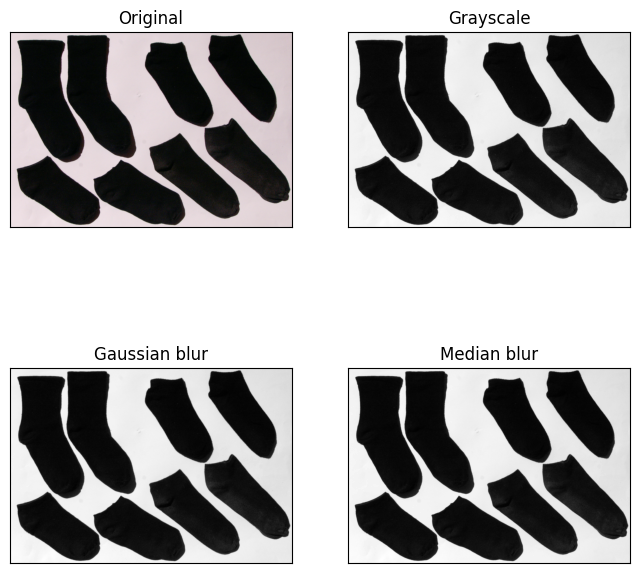

In [3]:

#Gaussian and median blur 
gau = cv.GaussianBlur(gray, (5, 5), 0)
median= cv.medianBlur(gray,5)

titles = ['Original', 'Grayscale', 'Gaussian blur', 'Median blur']
arr_img = [original, gray, gau, median]

plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(arr_img[i],'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show() 

Denoising - divison normalizaton 

In [4]:
#blur - division normalization
blur = cv.GaussianBlur(gray, (0,0),sigmaX=35,sigmaY=35) #, 

divide = cv.divide(gray,blur,scale=255)

th_divide = cv.threshold(gau,85, 255,cv.THRESH_BINARY)[1]
_, th1_divide = cv.threshold(gau, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

#apply moprhology
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
morph = cv.morphologyEx(th_divide, cv.MORPH_CLOSE, kernel)


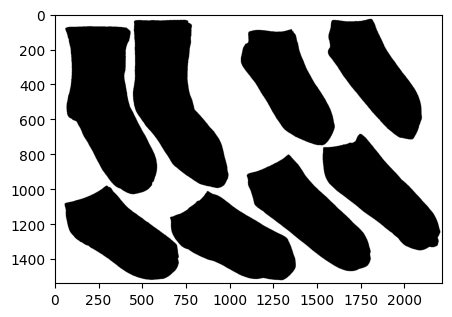

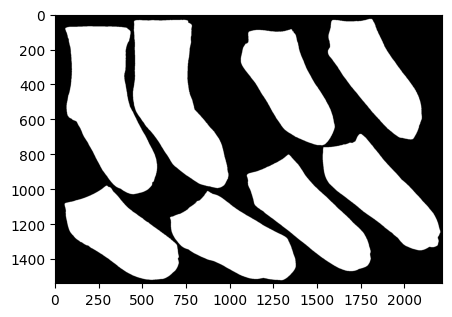

In [5]:
plt.figure(figsize=(5,5))
plt.imshow(morph, 'gray')

inverted_mask = cv.bitwise_not(morph)
plt.figure(figsize=(5,5))
plt.imshow(inverted_mask, 'gray')

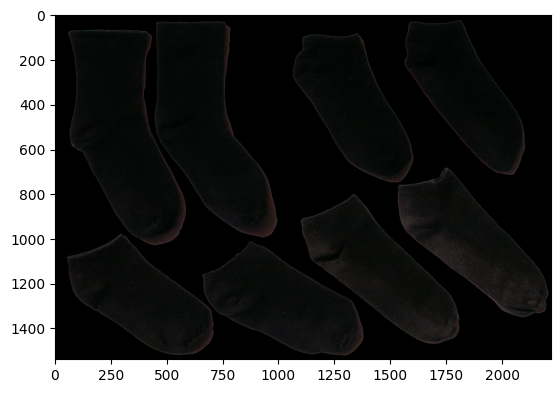

In [6]:
roi = cv.bitwise_and(original, original, mask=inverted_mask)
plt.imshow(roi)

Thresholding

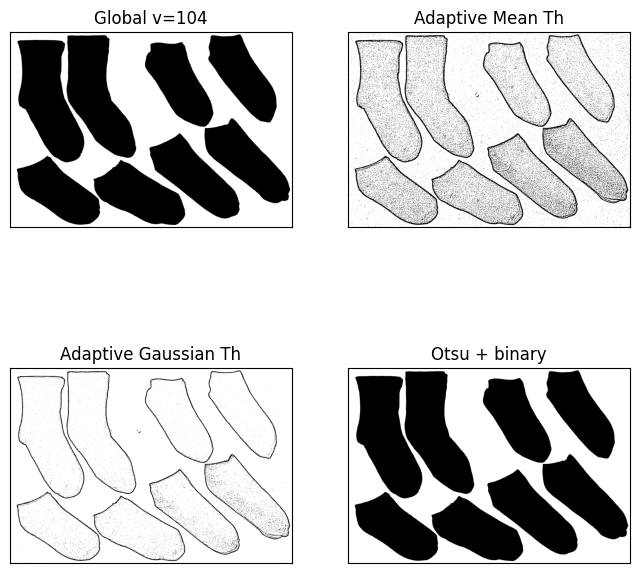

In [7]:
# Threshold the blurred image to get a binary image
_, th1 = cv.threshold(gau, 95, 255, cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(gau,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11,2)
th3 = cv.adaptiveThreshold(median, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11,2)
ret, th_otsu = cv.threshold(gau,0,255,cv.THRESH_OTSU+cv.THRESH_BINARY)

titles2 = ['Global v=104',  'Adaptive Mean Th', 'Adaptive Gaussian Th', 'Otsu + binary']
arr_th = [ th1,th2,th3, th_otsu]

plt.figure(figsize=(8,8))
for j in range(4):
    plt.subplot(2,2,j+1)
    plt.imshow(arr_th[j],'gray')
    plt.title(titles2[j])
    plt.xticks([])
    plt.yticks([])
plt.show()

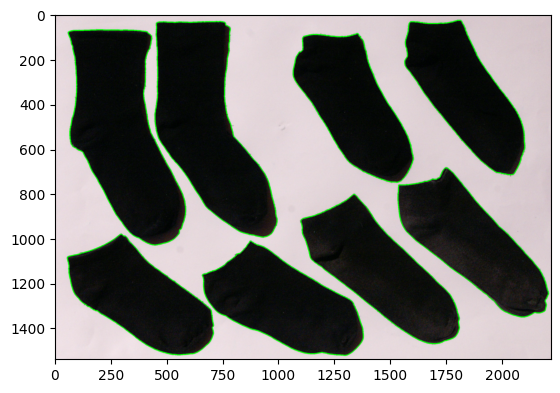

In [8]:

#contours, hier = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours, hier = cv.findContours(inverted_mask, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

contoursI = cv.drawContours(original, contours, -1, (0, 255, 0), 3)

plt.imshow(contoursI,'gray')

C:\Users\Admin\AppData\Local\Temp\ipykernel_24996\1938572712.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


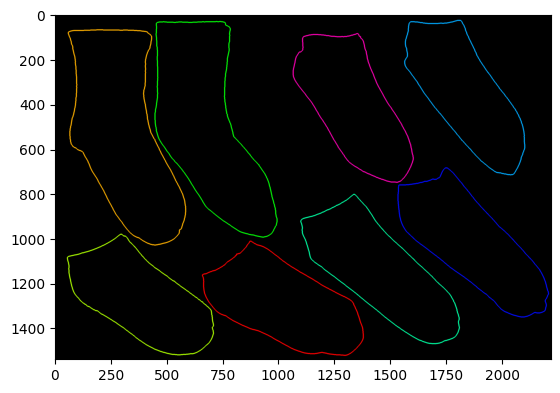

In [9]:
socks_contour = []
cmap = cm.get_cmap('hsv')
out = np.zeros_like(original)
for i, contour in enumerate(contours):
    if hier[0][i][2] < 0 and cv.contourArea(contour) > 600:
        color = np.round(np.array(cmap(i*57 % 255)[:-1])*255).astype(np.uint8) # Get the color from a colormap

        # If contour has no child, draw the contour
        cv.drawContours(out, contours, i, tuple(color.tolist()), 3)
        socks_contour.append( contour)
        

cv.imwrite('out.png', out)  # Save the result.
plt.imshow(out)


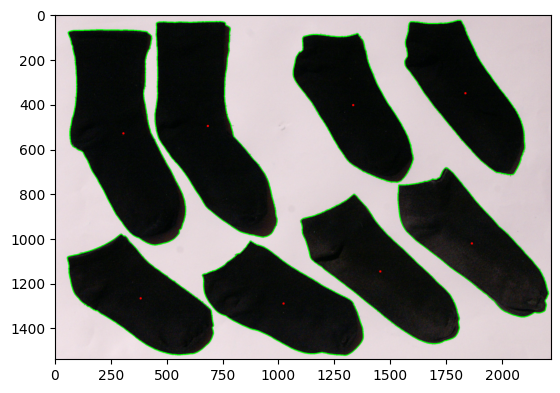

In [10]:


centroids = []

# Loop through all contours to compute centroids
for contour in socks_contour:

    M = cv.moments(contour)
    
    # Compute the centroid of the contour
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0
    
    centroids.append((cX, cY))


for centroid in centroids:
    cv.circle(original, centroid, 5, (255, 0, 0), -1)

plt.imshow(original)


In [11]:
len(centroids)

8

In [12]:

paired = []
unpaired = []


matched_indices = []
shape_matching_threshold = 0.4


for i in range(len(centroids)):
    # Skip contour if it's already matched
    if i in matched_indices:
        continue
    
    for j in range(i + 1, len(centroids)):
        # Skip contour if it's already matched
        if j in matched_indices:
            continue
        
        # Compute shape similarity 
        similarity = cv.matchShapes(socks_contour[i], socks_contour[j], cv.CONTOURS_MATCH_I1, 0.0)
        
        # If the shapes are similar, consider them as a pair
        if similarity < shape_matching_threshold:
            paired.append((centroids[i], centroids[j]))
            # Add indices to matched_indices
            matched_indices.extend([i, j])

# Loop through all centroids to find unpaired ones
for idx, centroid in enumerate(centroids):
    if idx not in matched_indices:
        unpaired.append(centroid)


print("Paired centroids:", paired)
print("Unpaired centroids:", unpaired)



Paired centroids: [((1020, 1291), (382, 1268)), ((1020, 1291), (1452, 1148)), ((1020, 1291), (1861, 1023)), ((1020, 1291), (1331, 406)), ((1020, 1291), (1832, 353)), ((305, 532), (682, 499))]
Unpaired centroids: []


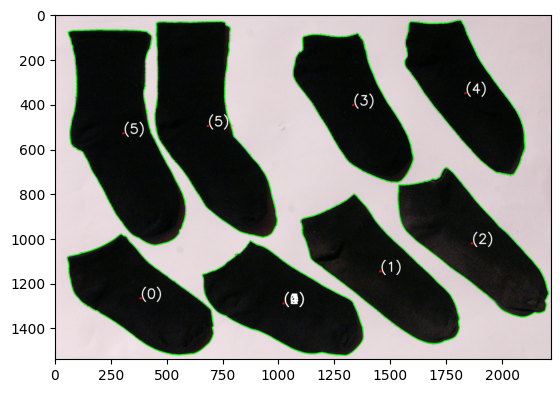

In [13]:

i=0
for pair in paired:
    
    x, y = pair[0]  
    z, v = pair[1]
    
    cv.putText(original, f'({i})', (x,y), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3, cv.LINE_AA)
    cv.putText(original, f'({i})', (z,v), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3, cv.LINE_AA)
    i+=1

for unpair in unpaired:
    
    x, y = unpair 
    cv.putText(original, f'(x)', (x,y), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 100, 250), 3, cv.LINE_AA)

plt.imshow(original)